#  04 - Estimating Mortality Rates through Puerto Rico
### by Ian Flores Siaca
##### October 2018

## Purpose of this Notebook

#### Learning
* Getting to know the `PyMC3` library
* Starting to think about Bayesian methods
* Think about uncertainty in the estimates instead of *significance vs no-significance* (*Not a fan of the p-value)

#### Project
* Estimate the mortality rate for urban areas as compared to rural areas.
* Identify which area needs more attention for future disasters.

### Bayesian methods

#### Bayesian Paradigm
** What if we have previous knowledge, or have expert knowledge regarding a certain subject that we would like to incorporate? ** With Bayesian methods, we can set something that is called a prior, which is a distribution for each parameter of the phenomenom we want to estimate or  test. We combine this priors with the data (a.k.a Likelihood) to obtain a posterior distribution which allows us the necessary inference.

> DISCLAIMER: Priors are controversial as some people have suggested that one can skew the results of the posterior distribution by setting the priors to certain values. This might be true in cases of few data points, however, in an open and reproducible science approach this should not be a concern as everyone alse can see your work. This is a big difference between using tools such as `R` and `Python` as compared to other click-and-touch software.

<img src="https://images.theconversation.com/files/166189/original/file-20170420-20093-1va7shd.jpg" height="400" width="300">

[Source: The Conversation](https://theconversation.com/bayes-theorem-the-maths-tool-we-probably-use-every-day-but-what-is-it-76140)

### History
* Thomas Bayes discovered it.
* Pierre-Simon Laplace greatly expanded the methods working with demographic data from France
    * Didn't know about Bayes discovery as British-French relations at the moment weren't great, even though Laplace was almost two centuries later. 
    * Also invented the Central Limit Theorem, a crucial mathematical concept to understand computation bayesian methods.
    * Invented the mathematical system for inductive reasoning in probability. 
    
### Uses

* Misile production estimation
    * Estimating the number of tanks the German Nazis were producing per factory
* Cracking the encryption
    * Breaking the Lorenz cipher using Bayesian methods
* Coast Guard Searchs
    * Searhing by quadrants for submarines in the Atlantic Ocean
* Election Prediction

### Let's code

#### Load the libraries

In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt

/home/kropotkin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Load the data

In [2]:
census_data = pd.read_csv("../data/census.csv")
census_data = census_data.drop(['Unnamed: 0'], axis = 1)

In [3]:
mortality_data = pd.read_csv("../data/mortality_grouped.csv")
mortality_data = mortality_data.drop(['Unnamed: 0'], axis = 1)

#### Calculating mortality rates
* We first join the census data to the mortality DataFrame. This order matters as the mortality DataFrame has more information than the census data. 
* We then divide the number of deaths by the number of people in each municipality and the multiply by 1000 to get the mortality rate per 1000 people. 

In [4]:
df = mortality_data.merge(census_data, on='ResidencePlace')
df['death_rate'] = (df['Deaths']/df['respop72017']) * 1000
df.head()

ResidencePlace ResidenceZone  Deaths  respop72017  death_rate
0       ADJUNTAS         RURAL      63        17971    3.505648
1       ADJUNTAS        URBANO      50        17971    2.782260
2         AGUADA         RURAL     165        38118    4.328664
3         AGUADA        URBANO      37        38118    0.970670
4      AGUADILLA         RURAL     320        53164    6.019111

Here we are making two DataFrames, one with the information for the rural zones and one for the urban zones.

In [5]:
rural = df[df['ResidenceZone'] == 'RURAL']['death_rate']
urban = df[df['ResidenceZone'] == 'URBANO']['death_rate']

`PyMC3`, the package we are using for Bayesian estimation, requires the data in a certain structure, which is what we are doing in this code cell below. 

In [6]:
total = pd.DataFrame(dict(death_rate = np.r_[rural, urban],
                         group = np.r_[['rural']* len(rural), 
                                      ['urban'] * len(urban)]))
total.head()

death_rate  group
0    3.505648  rural
1    4.328664  rural
2    6.019111  rural
3    5.299807  rural
4    4.111130  rural

#### Priors

As mentioned before, when doing bayesian estimation we need to set our priors. In this case I'm stating that our priors for the mean mortality rate in each zone should be close to the total death rate. In this case, I am modeling this priors with a TruncatedNormal distribution, bounded between 0 and a 1000, from the `PyMC3` library. This would mean the extreme of either no one dying or everyone dying respectively. As we don't know much about the variability of the data, we model it for both zones with a Uniform distribution between 0 and 10. `v` is the degrees of freedom, we are centering the mean around 2 in this case with a Gamma distribution. 

In [7]:
mu_total = total.death_rate.mean()
std_total = total.death_rate.std()

In [8]:
with pm.Model() as model:
    rural_mean = pm.TruncatedNormal('rural_mean', 
                                    mu = mu_total, 
                                    sd = std_total, 
                                    lower = 0, upper = 1000)
    urban_mean = pm.TruncatedNormal('urban_mean', 
                                    mu = mu_total, 
                                    sd = std_total, 
                                    lower = 0, upper = 1000)

In [9]:
std_low = 0
std_high = 10

with model:
    rural_std = pm.Uniform('rural_std', lower = std_low,
                          upper = std_high)
    urban_std = pm.Uniform('urban_std', lower = std_low, 
                          upper = std_high)

In [10]:
with model:
    v = pm.Gamma('v', alpha = 3, beta = 1)

#### Likelihood

In this code cell we are describing the final distribution, which is a StudentT distribution to compare the mean of the two groups at the end. We are passing the different arguments to the distribution and at the end with the `observed` argument we are feeding the model the data we have observed. 

In [11]:
with model:
    lambda_rural = rural_std**-2
    lambda_urban = urban_std**-2
    
    rural_try = pm.StudentT('rural', nu = v, mu = rural_mean, 
                            lam = lambda_rural, observed = rural)
    urban_try = pm.StudentT('urban', nu = v, mu = urban_mean, 
                           lam = lambda_urban, observed = urban)

Here, we are calculating the differences of the resulting distributions to see if there is a difference between both zones.

In [12]:
with model:
    diff_of_means = pm.Deterministic('difference of means', 
                                     rural_mean - urban_mean)
    
    diff_of_stds = pm.Deterministic('difference of stds', 
                                    rural_std - urban_std)

#### Sampling

We are going to take samples from this distributions, in our case it will be 20,000 samples, over 4 cores, discarding the first 15,000 samples in each chain. This leaves us with a total of 140,000 samples from the distributions. 

In [15]:
with model:
    trace = pm.sample(20000, cores = 4, tune = 15000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v, urban_std, rural_std, urban_mean, rural_mean]
Sampling 4 chains: 100%|██████████| 140000/140000 [01:21<00:00, 1714.77draws/s]


Let's look at the posterior of the mean of the mortality rate in urban zones. What do you see?

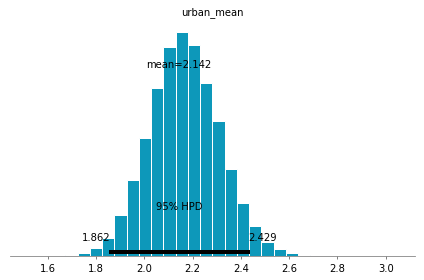

In [17]:
pm.plot_posterior(trace, varnames = ['urban_mean'], color = '#0d98ba')

We can observe that the mean is centered around 2.142 with a 95% chance that the real number is between 1.862 and 2.429, which means that we can say that in average, for every 1000 people, 2 died in urban zones. Below we can see that the standard deviation for the urban zones is 1.063. 

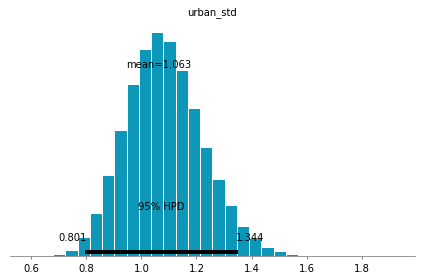

In [18]:
pm.plot_posterior(trace, varnames = ['urban_std'], color = '#0d98ba')

Now, let's look at the posterior of the mean of the mortality rate in rural zones. Do you notice a difference?

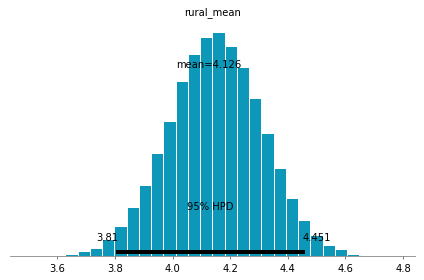

In [115]:
pm.plot_posterior(trace, varnames = ['rural_mean'], color = '#0d98ba')

We can observe that the mean is centered around 4.126 with a 95% chance that the real number is between 3.81 and 4.451, which means that we can say that in average, for every 1000 people, 4 died in rural zones. Below we can see that the standard deviation for the rural zones is 1.207, which means that the variability between urban and rural zones was similar. 

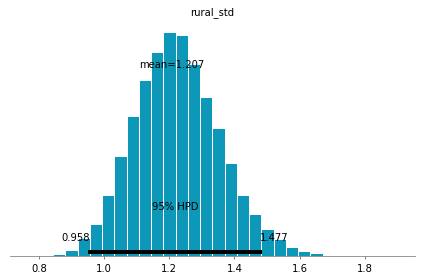

In [124]:
pm.plot_posterior(trace, varnames = ['rural_std'], color = '#0d98ba')

However, how does the rural distribution as a whole compare to the urban distribution?

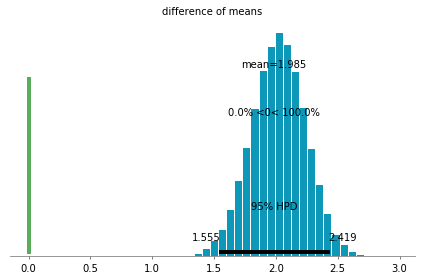

In [128]:
pm.plot_posterior(trace, varnames = ['difference of means'], color = '#0d98ba', ref_val=0)

Above we can see that approximately, in avergae, 2 more people died in rural zones as compared to urban zones. 

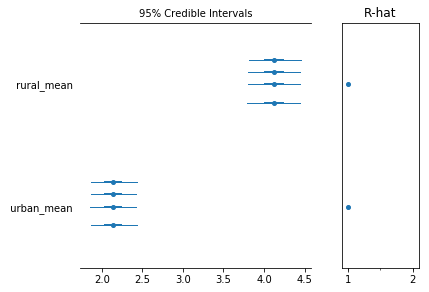

In [19]:
pm.forestplot(trace, varnames = ['rural_mean', 'urban_mean'])

Finally, if we compare the different chains of the sample visually we can see that they are all very diiferent between zones. 

### Optional Questions

1) Do you think this analysis could incorporate other variables? 
2) How do you think the results compare to the frequentist paradigm? Do you prefer to know the uncertainty in your results or have a single number to which you can refer to? 
3) I encourage you to play with the `PyMC3` package more as you can do very exciting things. (Such as model the result of football games)

### References

This work was inpired in part by this work done by the `PyMC3` development team:[https://docs.pymc.io/notebooks/BEST.html](https://docs.pymc.io/notebooks/BEST.html)

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.